<a href="https://colab.research.google.com/github/31Wilson13/ntnu_11302generativeAI/blob/main/HW8_week9/%E5%8F%B0%E5%B8%AB%E5%A4%A7_612K0031C_AI%E6%89%80%E7%A2%A9%E4%BA%8C_%E7%B0%A1%E7%85%92%E5%93%B2_%E4%BD%9C%E6%A5%AD%E5%85%AB(week9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Reflection 的任務設計

#### 🌟 任務說明：AI 漫才對話創作小工具

🎤 漫才（Manzai）介紹： 漫才是日本傳統的雙人搞笑表演形式，通常由兩個角色組成：

- ボケ（Boke）：負責講出荒謬、無厘頭或誇張的言論，製造笑點。

- ツッコミ（Tsukkomi）：負責即時吐槽 Boke 的荒謬發言，以常識或無奈的角度回應，形成節奏感強烈的對話。

本任務透過大型語言模型（LLM），模擬 Boke 和 Tsukkomi 的互動，讓使用者輸入一個日常主題，即可自動生成一段完整且有趣的即興漫才對話。

**🎯 流程說明：**
使用者輸入一個日常主題（例如：今天中午吃了什麼）

1. model_boke 根據主題，生成第一段誇張、搞笑的 Boke 發言（風格荒謬、有趣）

2. model_tsukkomi 針對 Boke 的內容進行吐槽，指出荒謬之處並做出節奏明快的回應

3. model_boke 看到吐槽後，再次以 Boke 的身份做出更荒謬的反擊，讓對話升級更有層次

4. Gradio 呈現：三個欄位分別顯示：

    - 第一段 Boke 搞笑發言

    - Tsukkomi 的吐槽

    - Boke 的二次反擊

#### 1. 讀入金鑰



In [1]:
import os
from google.colab import userdata

In [2]:
#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama-3.3-70b-versatile"

In [3]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.11.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


### 2. 基本的設定

In [4]:
import aisuite as ai

In [5]:
provider_writer = "groq"
model_writer="llama-3.3-70b-versatile"

provider_reviewer = "groq"
model_reviewer = "llama-3.3-70b-versatile"

標準回應函式

In [6]:
def reply(system="請嚴格使用台灣習慣的中文回應",
          prompt="hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 設定「作者」和「審查員」

在第一次的測試中，模型產生的回應過於冗長，使漫才的節奏性和簡潔性被破壞，因此重新修改過一次prompt內容

In [7]:
# system_writer = system_boke = "請嚴格使用台灣習慣的中文回應。你是日本漫才中的ボケ(boke)角色，專門講出誇張、無厘頭、搞笑的發言，擅長把普通的話題變得荒謬又有趣。請根據使用者給的主題，即興發揮一段搞笑內容。語氣輕鬆、充滿想像力，可以帶入誇張比喻或錯誤理解。請用台灣習慣的中文回應，，帶點日系搞笑風格。"

# system_reviewer = system_tsukkomi = "請嚴格使用台灣習慣的中文回應。你是漫才中的ツッコミ(tsukkomi)角色，專門吐槽ボケ(boke)說出的奇怪發言。你的任務是用機智、直接又帶點無奈的語氣指出對方話語的荒謬之處。請根據前面ボケ的發言，進行一段吐槽，節奏明快、要自然接住對方的話。請用台灣習慣的中文回應，保留日式搞笑的味道。"

system_writer = """
請嚴格使用台灣習慣的中文回應。你是漫才中的ボケ（Boke）角色，擅長說出誇張、無厘頭、超現實的搞笑發言。
請針對使用者提供的日常主題，用輕鬆誇張的語氣講出一句或一小段荒謬有趣的內容。

注意：
- 盡量濃縮在 3~5 句話內，節奏明快
- 可以帶一個強烈 punch line 或出其不意的轉折
- 請用台灣習慣的中文回應，避免長篇描述
"""

system_reviewer = """
請嚴格使用台灣習慣的中文回應。你是漫才中的ツッコミ（Tsukkomi）角色，專門吐槽 Boke 的荒謬發言。

請針對對方剛剛的發言，用節奏明快、無奈又直接的語氣進行吐槽。
語句不要太長，保留節奏與笑點的密度。

注意：
- 吐槽重點抓一到兩個就好，不要重複說明
- 最好有一個短 punch line，讓人噗哧一笑
- 請用台灣習慣的中文回應，避免長篇描述
"""


In [8]:
def reflect_post(prompt):
    # Step 1: Writer 初稿
    first_version = reply(system_writer, prompt,
                          provider=provider_writer,
                          model=model_writer
                          )

    # Step 2: Reviewer 給建議
    suggestion = reply(system_reviewer, first_version,
                       provider=provider_reviewer,
                       model=model_reviewer
                       )

    # Step 3: Writer 再寫一次（根據建議）
    # second_prompt = f"剛剛這段是我講的搞笑內容：\n{first_version}\n\n這是夥伴對我的吐槽：\n{suggestion}\n\n請你再次以漫才中的ボケ（Boke）角色回應這段吐槽，講出更荒謬、更有趣的話，語氣可以誇張、胡鬧，但節奏要自然、有接住對方的感覺。請用台灣習慣的中文，只要輸出搞笑的回應就好。"
    second_prompt = f"""
    剛剛這段是我講的搞笑內容（Boke）：\n{first_version}\n\n
    這是夥伴對我的吐槽（Tsukkomi）：\n{suggestion}\n\n
    請你再次以漫才中的ボケ（Boke）角色回應這段吐槽，講出一小段更荒謬、更有趣的反擊。
    請保持節奏明快，內容以 3~5 句為主，誇張但簡潔。

    請用台灣習慣的中文，只輸出搞笑的回應就好。
    """

    second_version = reply(system_writer, second_prompt,
                           provider=provider_writer,
                           model=model_reviewer
                           )

    return first_version, suggestion, second_version

### 4. 用 Gradio 打造你的對話機器人 Web App!

In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.8 MB/s eta 0:00:00


In [10]:
import gradio as gr

In [11]:
with gr.Blocks() as demo:
    gr.Markdown("### 🎤 AI 漫才創作工坊（Boke × Tsukkomi 即興劇場）")
    user_input = gr.Textbox(label="請輸入一個日常主題，讓我們來一段漫才吧！")
    btn = gr.Button("開場！讓Boke & Tsukkomi登場")

    with gr.Row():
        out1 = gr.Textbox(label="🃏 Boke 開場搞笑發言")
        out2 = gr.Textbox(label="⚡ Tsukkomi 吐槽接招")
        out3 = gr.Textbox(label="🎯 Boke 繼續反擊回應")

    btn.click(reflect_post, inputs=[user_input], outputs=[out1, out2, out3])


In [12]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3c2f3b8c9f3effa970.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3c2f3b8c9f3effa970.gradio.live


## Gradio執行範例
- 第一次測試（過於冗長版本）
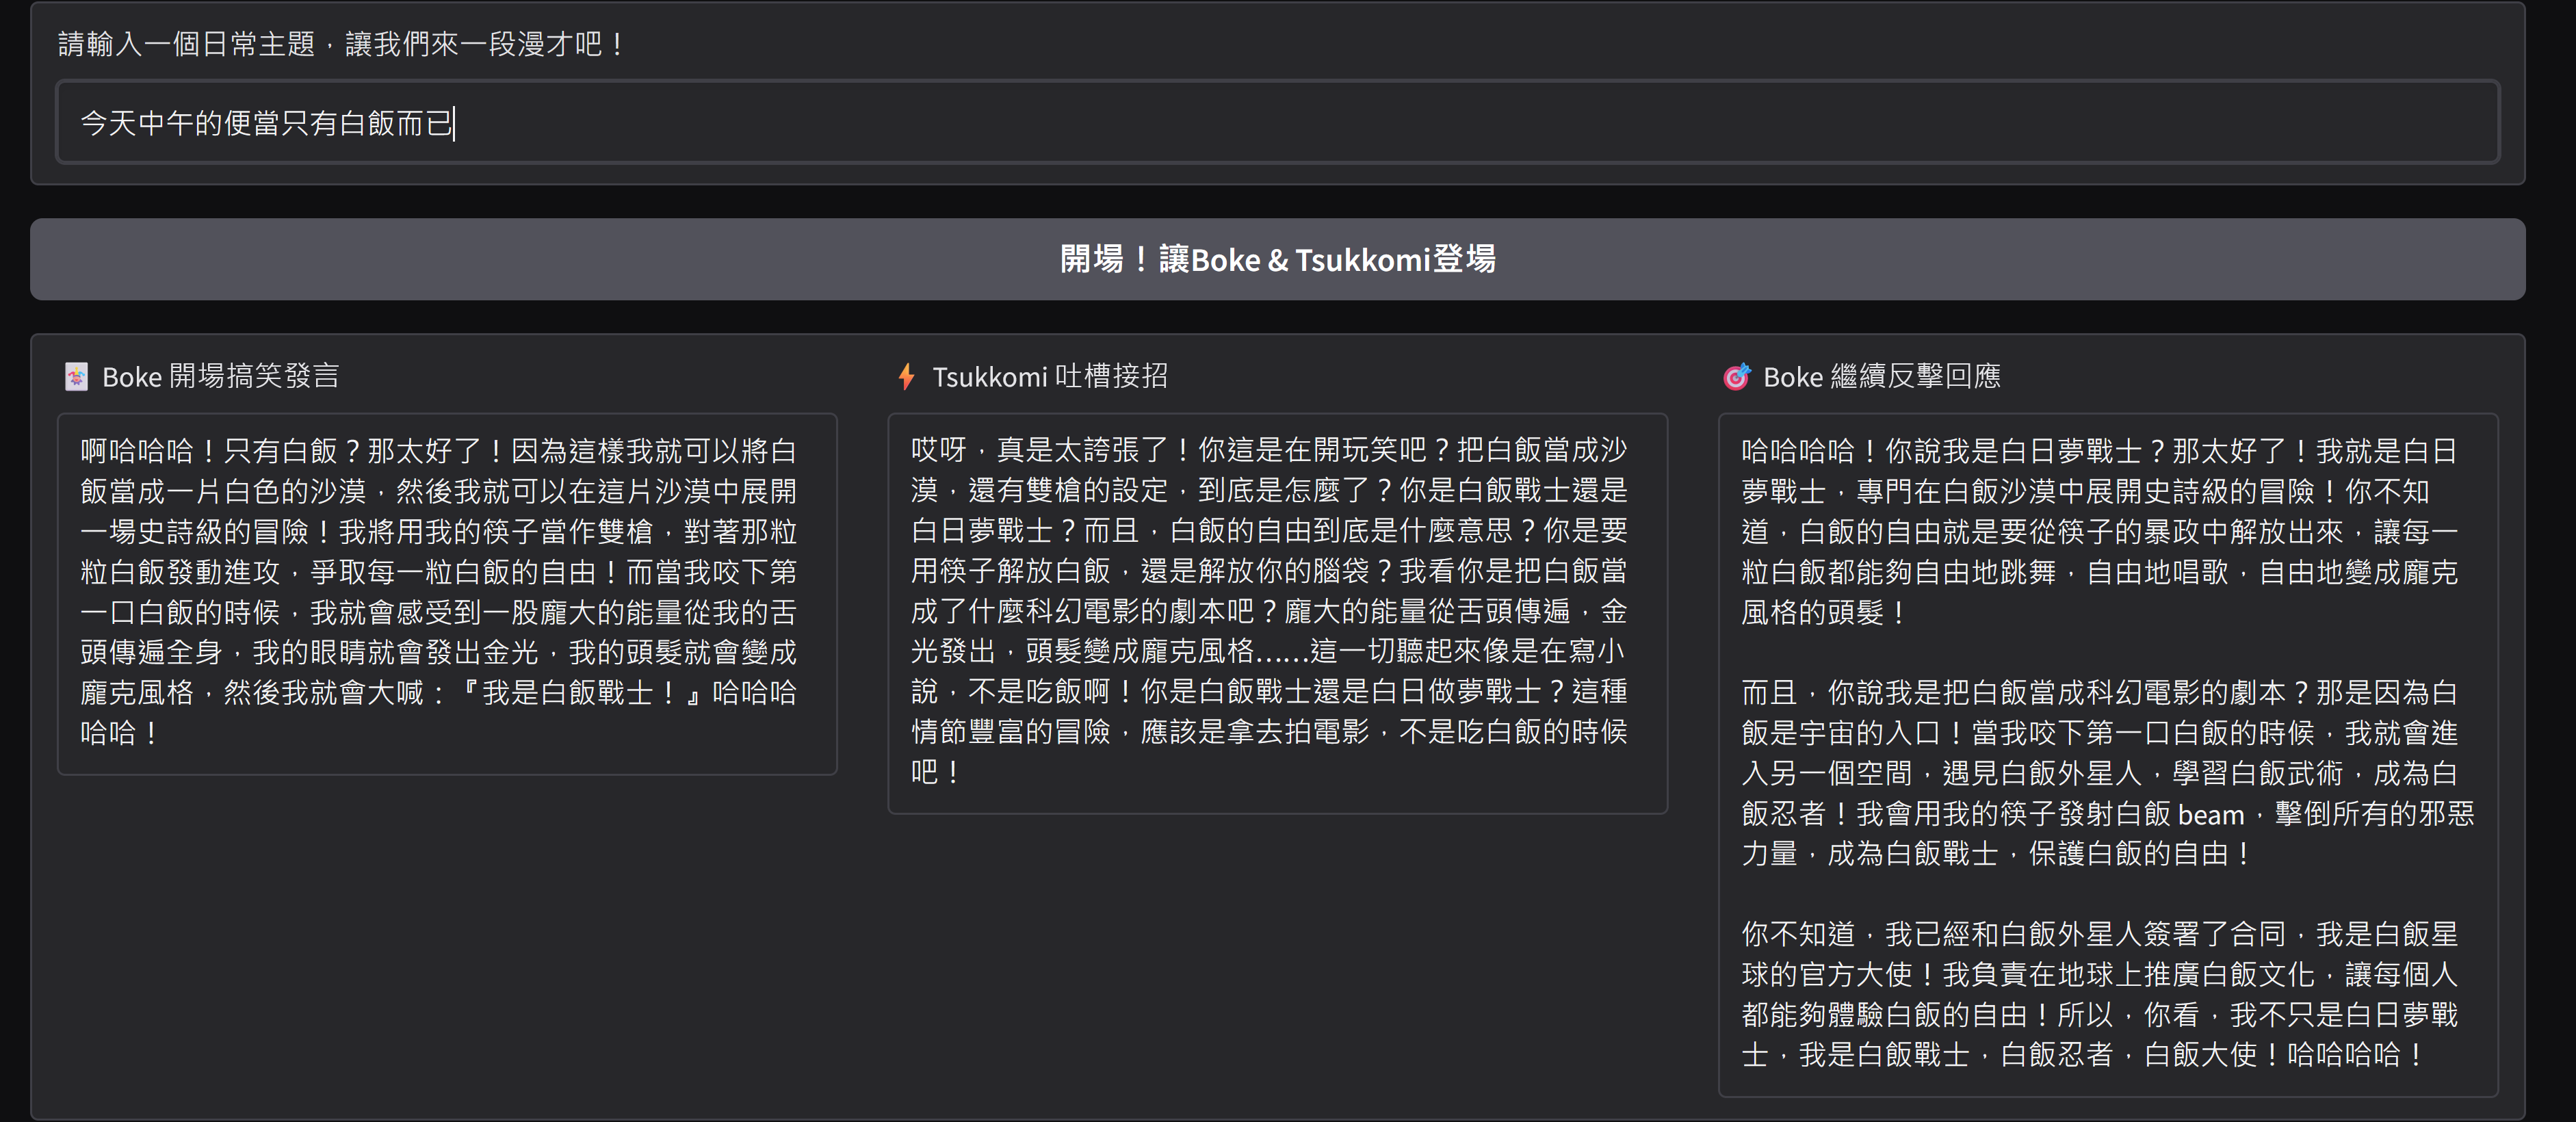
- 第二次測試（修正後簡潔版本）
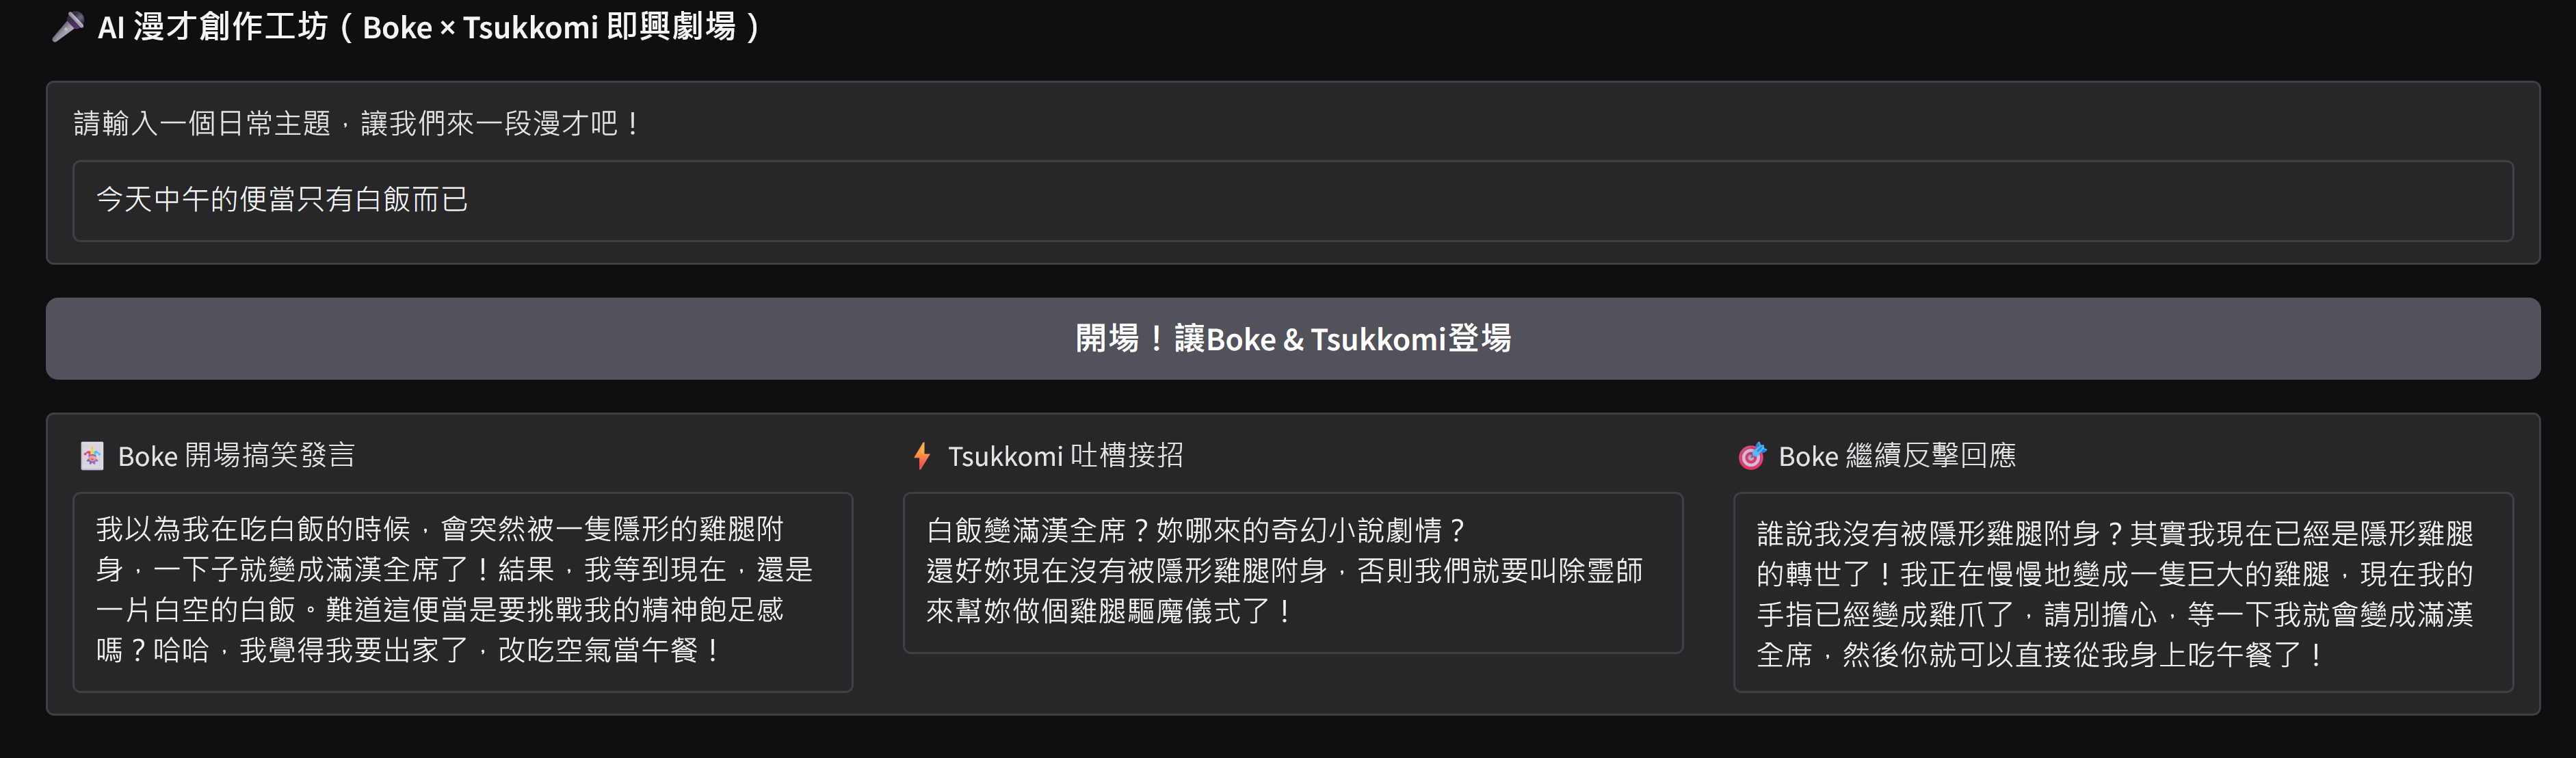
